## Many Models with purrr and broom

In [2]:
library (modelr)
library (tidyverse)
library (broom)


Attaching package: 'broom'

The following object is masked from 'package:modelr':

    bootstrap



In [5]:
library (gapminder)
gapminder %>% print()

# A tibble: 1,704 x 6
       country continent  year lifeExp      pop gdpPercap
        <fctr>    <fctr> <int>   <dbl>    <int>     <dbl>
 1 Afghanistan      Asia  1952  28.801  8425333  779.4453
 2 Afghanistan      Asia  1957  30.332  9240934  820.8530
 3 Afghanistan      Asia  1962  31.997 10267083  853.1007
 4 Afghanistan      Asia  1967  34.020 11537966  836.1971
 5 Afghanistan      Asia  1972  36.088 13079460  739.9811
 6 Afghanistan      Asia  1977  38.438 14880372  786.1134
 7 Afghanistan      Asia  1982  39.854 12881816  978.0114
 8 Afghanistan      Asia  1987  40.822 13867957  852.3959
 9 Afghanistan      Asia  1992  41.674 16317921  649.3414
10 Afghanistan      Asia  1997  41.763 22227415  635.3414
# ... with 1,694 more rows


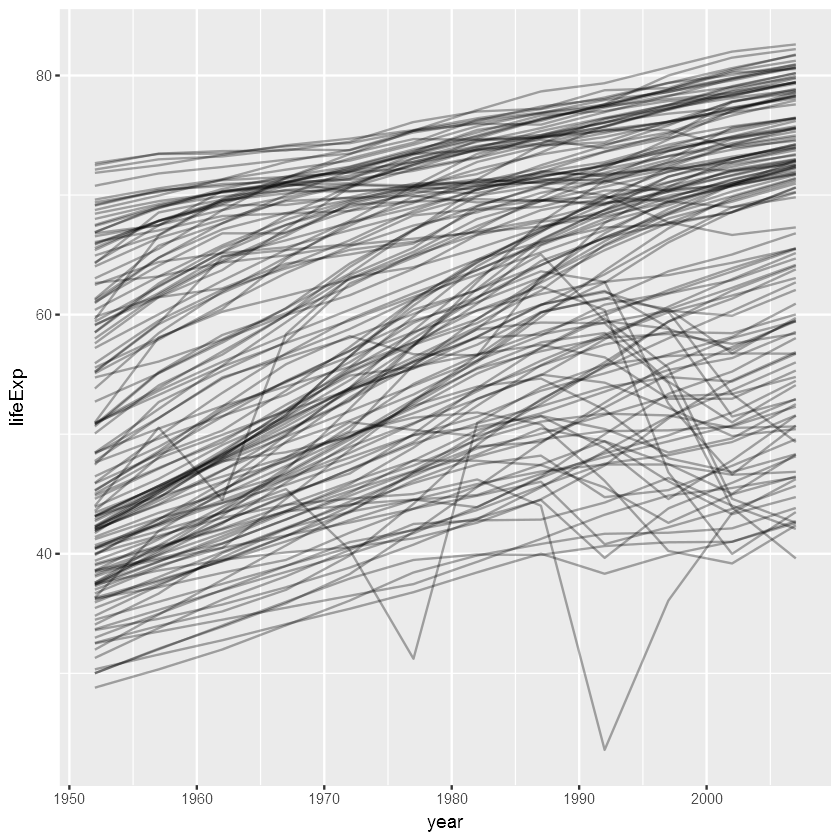

In [7]:
gapminder %>%
    ggplot(aes(year, lifeExp, group = country)) + 
    geom_line (alpha = 1/3)


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



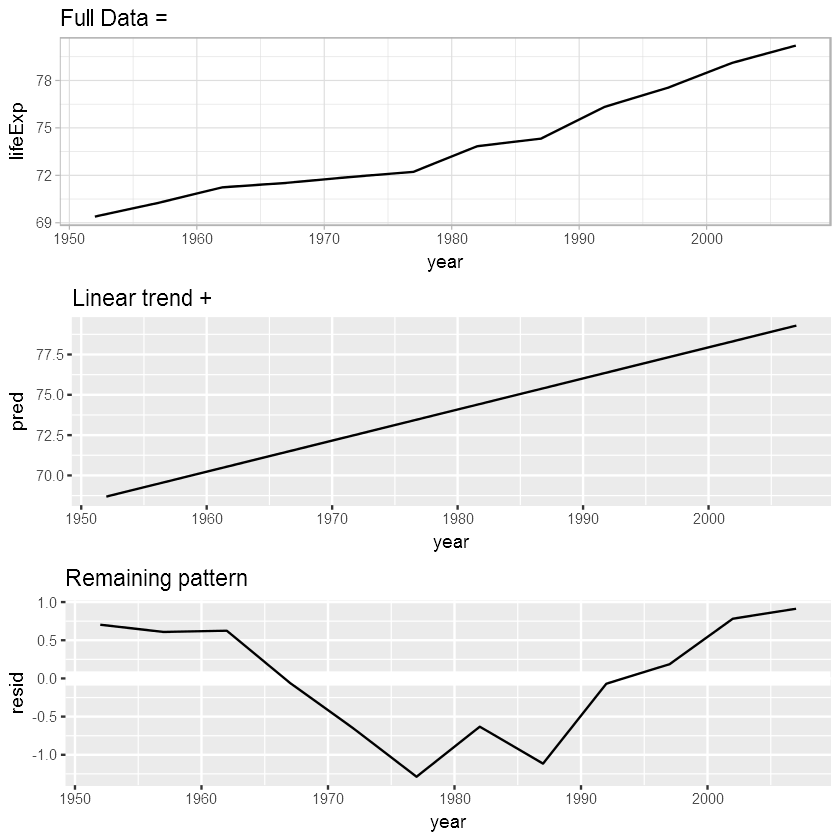

In [10]:
## 右肩上がりの傾向があるが, 一部のデータにはその傾向がない
## 傾向がないデータを効率的に見つけるには?
library (gridExtra)
nz <- filter (gapminder, country == "New Zealand")
nz_mod <- lm (lifeExp ~ year, data=nz)

grid.arrange(


nz %>%
    ggplot(aes(year, lifeExp)) + 
    geom_line () + 
    ggtitle ("Full Data = ") + 
    theme_light()
,
nz %>%
    add_predictions(nz_mod) %>%
    ggplot(aes(year, pred)) + 
    geom_line () +
    ggtitle ("Linear trend + ")
,
nz %>%
    add_residuals(nz_mod) %>%
    ggplot(aes(year, resid))  +
    geom_hline (yintercept=0, color="white", size=3) + 
    geom_line() + 
    ggtitle("Remaining pattern")
,
nrow = 3
)

### Nested Data

上記のような当てはめをすべての国に対して実行するには?

In [14]:
## リストが要素のデータフレームを作成する
by_country <- gapminder %>%
    group_by (country, continent) %>%
    nest()
by_country %>% print()

# A tibble: 142 x 3
       country continent              data
        <fctr>    <fctr>            <list>
 1 Afghanistan      Asia <tibble [12 x 4]>
 2     Albania    Europe <tibble [12 x 4]>
 3     Algeria    Africa <tibble [12 x 4]>
 4      Angola    Africa <tibble [12 x 4]>
 5   Argentina  Americas <tibble [12 x 4]>
 6   Australia   Oceania <tibble [12 x 4]>
 7     Austria    Europe <tibble [12 x 4]>
 8     Bahrain      Asia <tibble [12 x 4]>
 9  Bangladesh      Asia <tibble [12 x 4]>
10     Belgium    Europe <tibble [12 x 4]>
# ... with 132 more rows


#### List-Columns

In [17]:
country_model <- function (df) {
    lm(lifeExp ~ year, data=df)
}
by_country <- by_country %>%
    mutate (model = map (data, country_model))
by_country %>% print()

# A tibble: 142 x 4
       country continent              data    model
        <fctr>    <fctr>            <list>   <list>
 1 Afghanistan      Asia <tibble [12 x 4]> <S3: lm>
 2     Albania    Europe <tibble [12 x 4]> <S3: lm>
 3     Algeria    Africa <tibble [12 x 4]> <S3: lm>
 4      Angola    Africa <tibble [12 x 4]> <S3: lm>
 5   Argentina  Americas <tibble [12 x 4]> <S3: lm>
 6   Australia   Oceania <tibble [12 x 4]> <S3: lm>
 7     Austria    Europe <tibble [12 x 4]> <S3: lm>
 8     Bahrain      Asia <tibble [12 x 4]> <S3: lm>
 9  Bangladesh      Asia <tibble [12 x 4]> <S3: lm>
10     Belgium    Europe <tibble [12 x 4]> <S3: lm>
# ... with 132 more rows


In [18]:
by_country <- by_country %>%
    mutate (
        resids = map2(data, model, add_residuals)
    )
by_country %>% print()

# A tibble: 142 x 5
       country continent              data    model            resids
        <fctr>    <fctr>            <list>   <list>            <list>
 1 Afghanistan      Asia <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 2     Albania    Europe <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 3     Algeria    Africa <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 4      Angola    Africa <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 5   Argentina  Americas <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 6   Australia   Oceania <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 7     Austria    Europe <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 8     Bahrain      Asia <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
 9  Bangladesh      Asia <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
10     Belgium    Europe <tibble [12 x 4]> <S3: lm> <tibble [12 x 5]>
# ... with 132 more rows


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


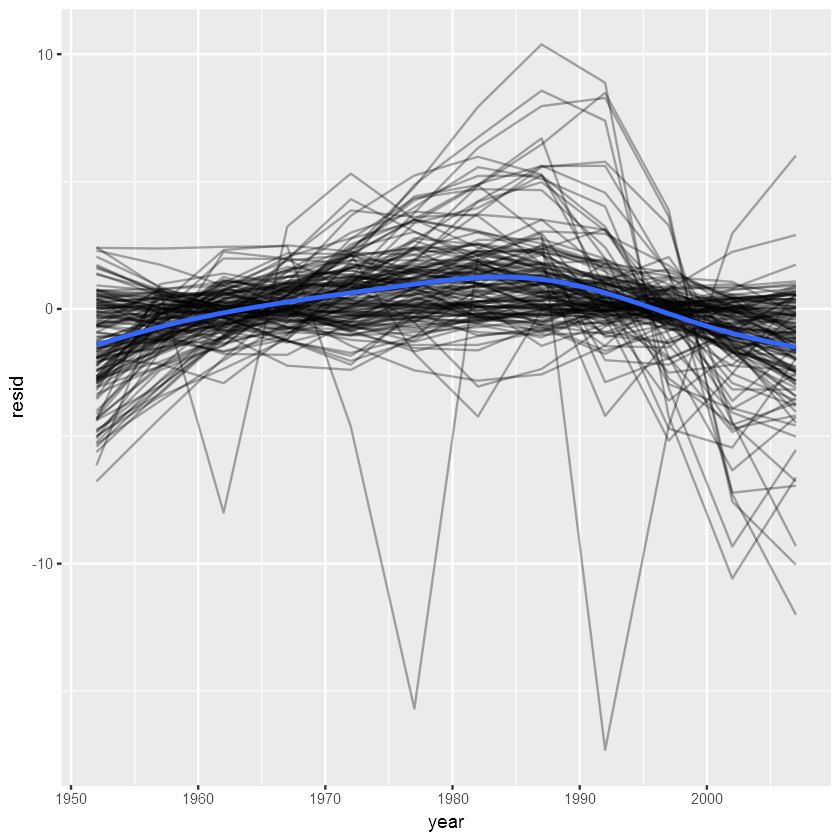

In [21]:
## nestさせたデータは, unnestすればよい
resids <- unnest(by_country, resids)
resids %>%
    ggplot(aes(year, resid)) + 
    geom_line (aes(group = country), alpha = 1/ 3) + 
    geom_smooth(se= FALSE)

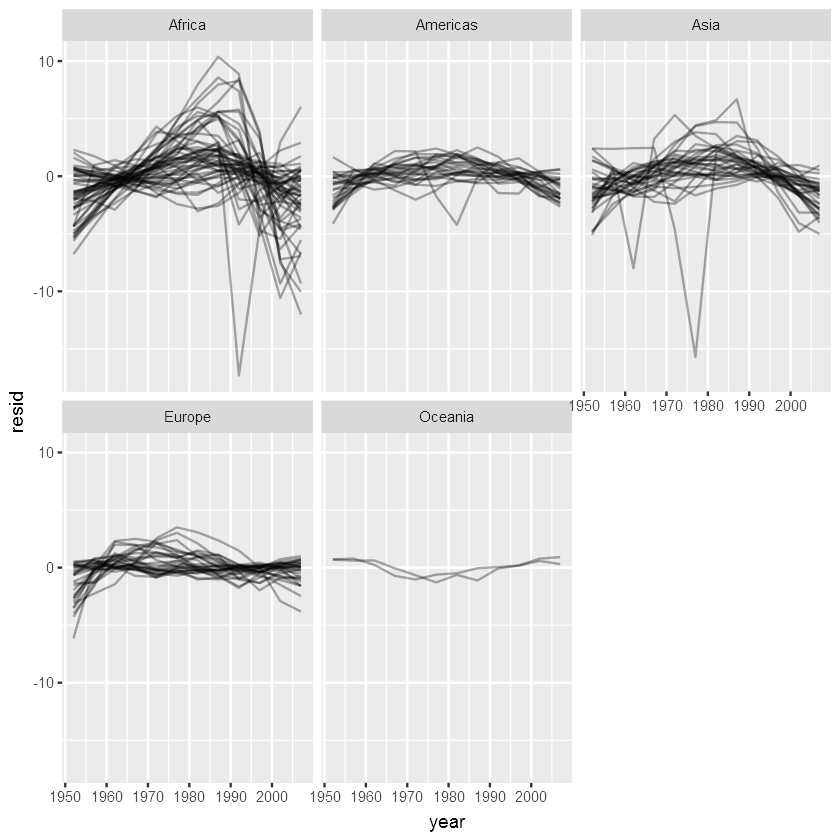

In [23]:
## グラフをみると特にアフリカで大きく値が外れているようにみえるので
## モデルが適切でない可能性が大きい
resids %>%
    ggplot(aes(year, resid, group = country)) + 
    geom_line(alpha = 1/3) + 
    facet_wrap( ~ continent)

#### Model Quality

In [30]:
## broomパッケージで, モデルの指標を確認
glance <-
    by_country %>%
    mutate (glance = map (model, broom::glance)) %>%
    unnest (glance, .drop=TRUE)
glance %>% print()

# A tibble: 142 x 13
       country continent r.squared adj.r.squared     sigma  statistic
        <fctr>    <fctr>     <dbl>         <dbl>     <dbl>      <dbl>
 1 Afghanistan      Asia 0.9477123     0.9424835 1.2227880  181.24941
 2     Albania    Europe 0.9105778     0.9016355 1.9830615  101.82901
 3     Algeria    Africa 0.9851172     0.9836289 1.3230064  661.91709
 4      Angola    Africa 0.8878146     0.8765961 1.4070091   79.13818
 5   Argentina  Americas 0.9955681     0.9951249 0.2923072 2246.36635
 6   Australia   Oceania 0.9796477     0.9776125 0.6206086  481.34586
 7     Austria    Europe 0.9921340     0.9913474 0.4074094 1261.29629
 8     Bahrain      Asia 0.9667398     0.9634138 1.6395865  290.65974
 9  Bangladesh      Asia 0.9893609     0.9882970 0.9766908  929.92637
10     Belgium    Europe 0.9945406     0.9939946 0.2929025 1821.68840
# ... with 132 more rows, and 7 more variables: p.value <dbl>, df <int>,
#   logLik <dbl>, AIC <dbl>, BIC <dbl>, deviance <dbl>, df.residua

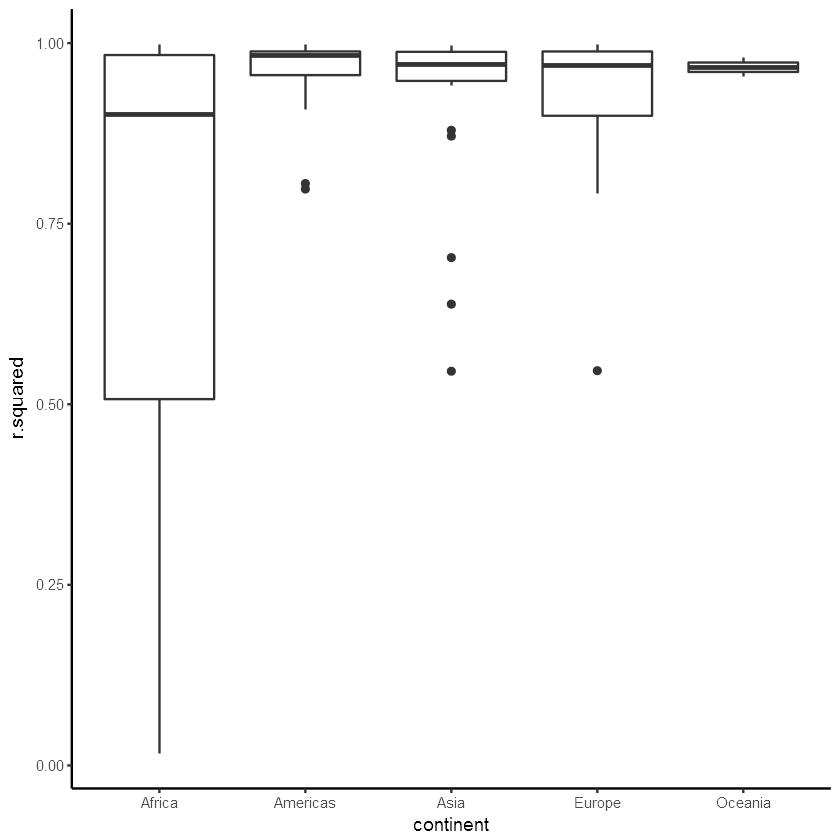

In [32]:
## 地域別にr.squaredに偏りが存在することを確認する
ggplot(glance, aes(continent, r.squared)) + 
    geom_boxplot() +
    theme_classic()

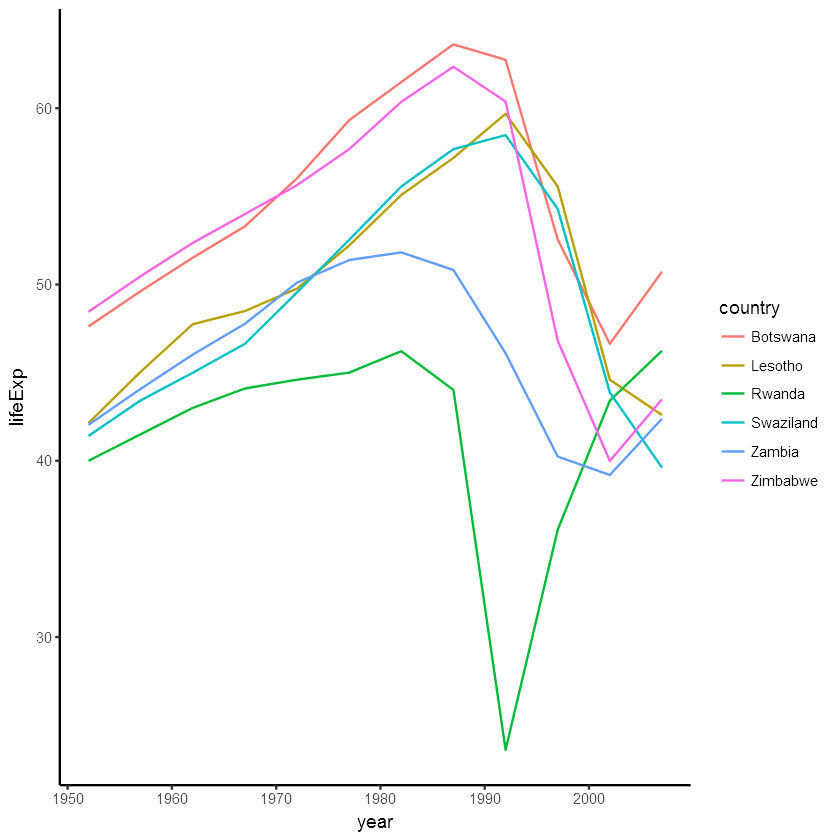

In [35]:
## R2を指標として, 当てはまりが悪いモデルを抽出する
bad_fit <- filter (glance, r.squared < .25)
gapminder %>%
    semi_join(bad_fit, by="country") %>% # y.key一致するx.keyを持つレコードを残す
    ggplot(aes(year, lifeExp, color=country)) +
    geom_line() + 
    theme_classic()

### ELSE


In [38]:
df <- tribble (
    ~x1, 
    "a,b,c", 
    "d,e,f,g"
)
sp_df <-
    df %>%
    mutate (x2 = stringr::str_split(x1, ","))
sp_df %>% print()

# A tibble: 2 x 2
       x1        x2
    <chr>    <list>
1   a,b,c <chr [3]>
2 d,e,f,g <chr [4]>


In [42]:
sp_df %>% unnest(x2) %>% print()

# A tibble: 7 x 2
       x1    x2
    <chr> <chr>
1   a,b,c     a
2   a,b,c     b
3   a,b,c     c
4 d,e,f,g     d
5 d,e,f,g     e
6 d,e,f,g     f
7 d,e,f,g     g


In [46]:
probs <- seq(.1, 1, .1)
mtcars %>%
    group_by (cyl) %>%
    summarise (p = list (probs), q = list (quantile (mpg, probs))) %>%
    unnest(p, q) %>% print()

# A tibble: 30 x 3
     cyl     p     q
   <dbl> <dbl> <dbl>
 1     4   0.1  21.5
 2     4   0.2  22.8
 3     4   0.3  22.8
 4     4   0.4  24.4
 5     4   0.5  26.0
 6     4   0.6  27.3
 7     4   0.7  30.4
 8     4   0.8  30.4
 9     4   0.9  32.4
10     4   1.0  33.9
# ... with 20 more rows


In [47]:
theme_bw()

List of 57
 $ line                 :List of 6
  ..$ colour       : chr "black"
  ..$ size         : num 0.5
  ..$ linetype     : num 1
  ..$ lineend      : chr "butt"
  ..$ arrow        : logi FALSE
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_line" "element"
 $ rect                 :List of 5
  ..$ fill         : chr "white"
  ..$ colour       : chr "black"
  ..$ size         : num 0.5
  ..$ linetype     : num 1
  ..$ inherit.blank: logi TRUE
  ..- attr(*, "class")= chr [1:2] "element_rect" "element"
 $ text                 :List of 11
  ..$ family       : chr ""
  ..$ face         : chr "plain"
  ..$ colour       : chr "black"
  ..$ size         : num 11
  ..$ hjust        : num 0.5
  ..$ vjust        : num 0.5
  ..$ angle        : num 0
  ..$ lineheight   : num 0.9
  ..$ margin       :Classes 'margin', 'unit'  atomic [1:4] 0 0 0 0
  .. .. ..- attr(*, "valid.unit")= int 8
  .. .. ..- attr(*, "unit")= chr "pt"
  ..$ debug        : logi FALSE
  ..$ inherit.

In [49]:
?geom_line

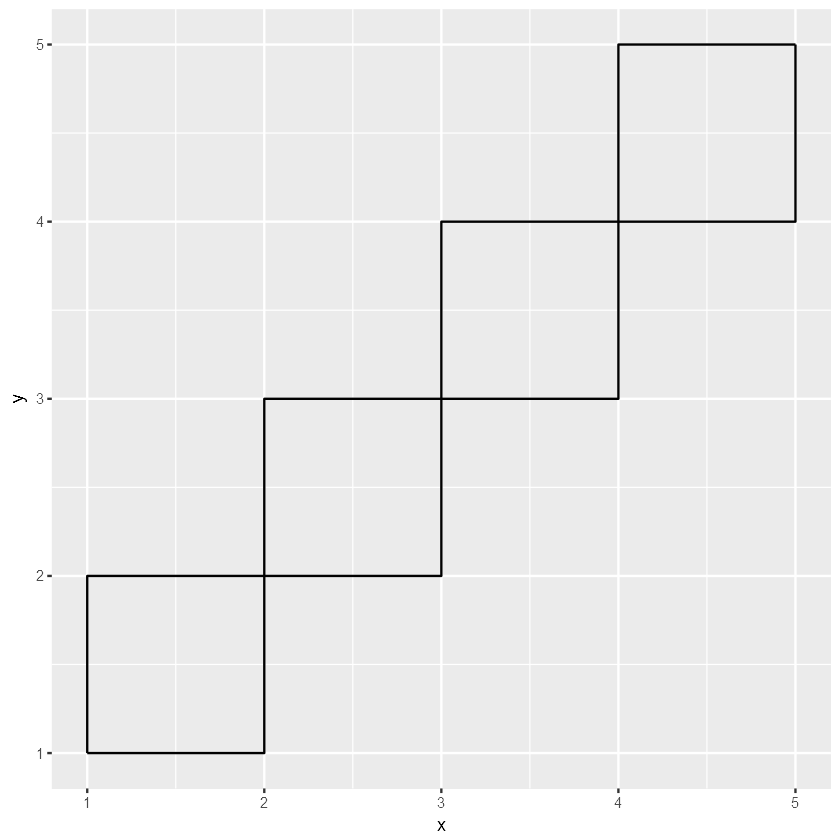

In [52]:
a <- data_frame (x = 1:5, y = 1:5)
a %>% ggplot() + geom_step(aes(x, y)) +geom_step(aes(x, y), direction="vh")

Loading required package: viridisLite


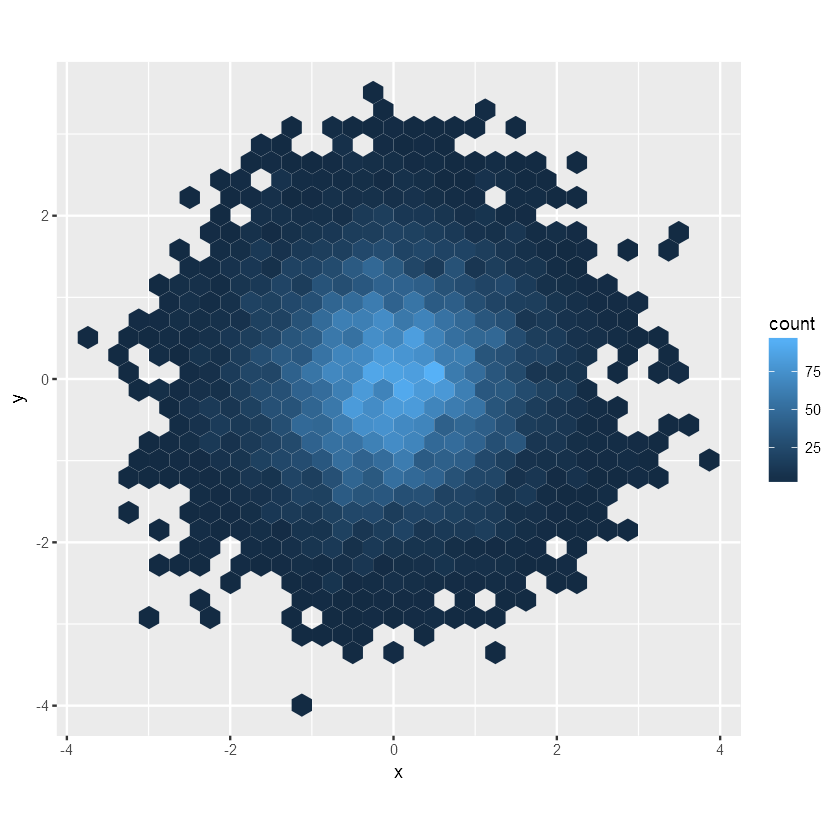

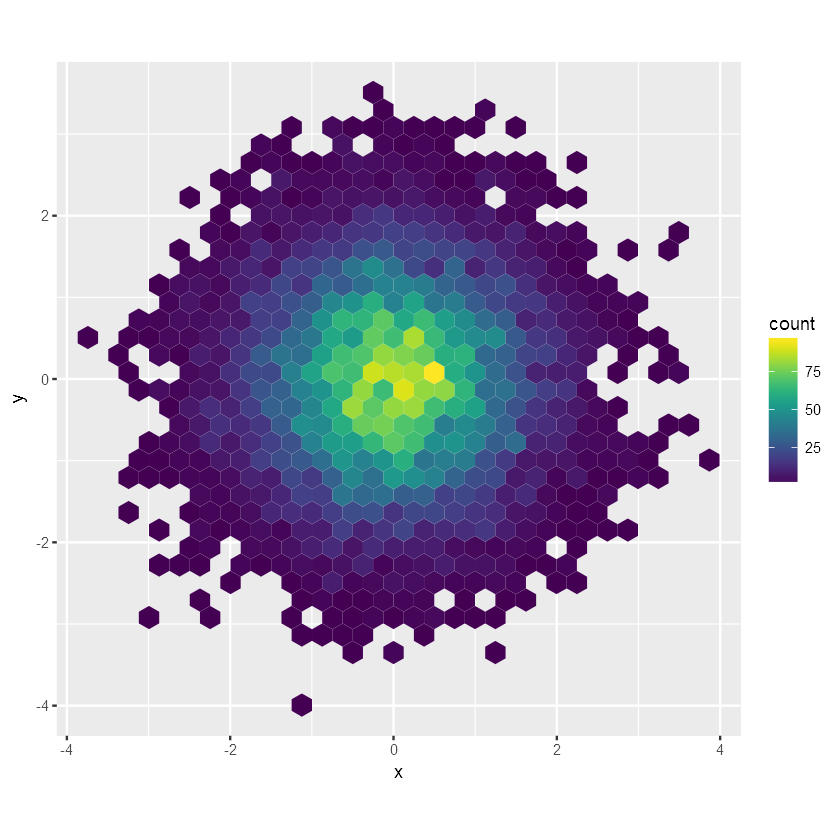

In [54]:
library (viridis)
df <- tibble(
    x = rnorm (10000), 
    y = rnorm (10000)
)
b <- 
    ggplot(df, aes(x,y)) + 
    geom_hex() + 
    coord_fixed()
b
b + scale_fill_viridis()
    

In [ ]:
    g